In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# Base libraries
import os
import random

# Keras libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, Softmax
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.8.2


# 1.유틸

In [2]:
def save_model(model_name: str, model: keras.models.Model):
    model_json = model.to_json()
    with open(model_name, "w") as json_file:
        json_file.write(model_json)

from keras.models import model_from_json
from typing import Optional

In [3]:
def load_model(
    model_name: str, with_weights_path: Optional[str] = None
) -> keras.models.Model:
    json_file = open(model_name, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    if with_weights_path:
        model.load_weights(with_weights_path)
    return model

## 1.1.구글 드라이브 설정

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


여러분의 설정한 구글 드라이브의 폴더 이름을 넣습니다.

In [5]:
import os
base_gdrive_path = os.path.join("drive", "MyDrive", "lecture_220718")

설정한 구글 드라이브 폴더의 하위에 `results` 라는 이름의 폴더를 설정합니다.

In [6]:
from pathlib import Path
import os

result_path = os.path.join(base_gdrive_path, "results")
Path(result_path).mkdir(parents=True, exist_ok=True)

# 2.LOL Dataset

https://figshare.com/articles/dataset/camvid/17080916 이 사이트에서 자료를 받습니다. (아래 줄을 실행하시면 받을 수 있습니다.)


파일(186MB)에 대한 직접적인 링크는 아래와 같습니다.

https://figshare.com/ndownloader/files/31579223 


In [7]:
!gdown https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6
!unzip -q lol_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6
To: /content/lol_dataset.zip
100% 347M/347M [00:02<00:00, 129MB/s]


마스크 라벨 등에 대한 설명이 필요하다면 다음 링크를 참고합니다.

https://www.kaggle.com/datasets/carlolepelaars/camvid

## 2.1.가져오기

LOL Dataset은 tfds에 없으므로, 직접 만들어야 합니다.


| 구분 | 개수 |
| --- | --- |
|'test(eval)'|15|
|'train'|485|


In [8]:
import tensorflow as tf
import numpy as np
from glob import glob

In [10]:
random.seed(10)

IMAGE_SIZE = 128
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 300

In [11]:
def read_image(image_path: str, as_grayscale: bool = False) -> tf.Tensor:
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image

In [12]:
def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    enhanced_w = low_w
    enhanced_h = low_h
    low_image_cropped = low_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        enhanced_h : enhanced_h + IMAGE_SIZE, enhanced_w : enhanced_w + IMAGE_SIZE
    ]
    return low_image_cropped, enhanced_image_cropped

In [13]:
def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image


In [14]:
def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


In [15]:
train_low_light_images = sorted(glob("/content/lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob("/content/lol_dataset/our485/high/*"))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(glob("/content/lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(glob("/content/lol_dataset/our485/high/*"))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob("/content/lol_dataset/eval15/low/*"))
test_enhanced_images = sorted(glob("/content/lol_dataset/eval15/high/*"))


In [16]:
train_low_image_path = "/content/lol_dataset/our485/high"
train_high_image_path = "/content/lol_dataset/our485/low"

test_low_image_path = "/content/lol_dataset/eval485/high"
test_high_image_path = "/content/lol_dataset/eval485/low"


In [17]:
train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)


In [18]:
print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, None, None, 3), dtype=tf.float32, name=None))>


## 2.2.단일 데이터 살펴보기

데이터 세트 하나를 가져와서 살펴봅니다.

In [19]:
sample_data = list(train_dataset.take(1))[0]

In [20]:
sample_data

(<tf.Tensor: shape=(4, 128, 128, 3), dtype=float32, numpy=
 array([[[[0.07843138, 0.08235294, 0.07450981],
          [0.08235294, 0.07843138, 0.07450981],
          [0.07843138, 0.09019608, 0.07450981],
          ...,
          [0.04313726, 0.05098039, 0.02745098],
          [0.0627451 , 0.05882353, 0.03921569],
          [0.06666667, 0.05098039, 0.03137255]],
 
         [[0.07843138, 0.07843138, 0.07450981],
          [0.08627451, 0.08235294, 0.07058824],
          [0.07450981, 0.07450981, 0.07058824],
          ...,
          [0.05098039, 0.05098039, 0.02352941],
          [0.05882353, 0.05490196, 0.04313726],
          [0.04313726, 0.05098039, 0.03921569]],
 
         [[0.07843138, 0.07843138, 0.0627451 ],
          [0.09019608, 0.07843138, 0.07058824],
          [0.08235294, 0.07843138, 0.06666667],
          ...,
          [0.05490196, 0.05098039, 0.01960784],
          [0.05098039, 0.05882353, 0.01960784],
          [0.05490196, 0.05490196, 0.02745098]],
 
         ...,
 
       

1. low 이미지 - (height, width, 3)
    - RGB 컬러 이미지
2. high 이미지 - (height, width, 3)
    - RGB 컬러 이미지
         

# 3.전처리

전처리는 앞에서 다 진행하였습니다.

1) 샘플 보기

In [21]:
sample_low_image_1, sample_high_image_1 = list(train_dataset.take(2))[1]

In [22]:
import matplotlib.pyplot as plt

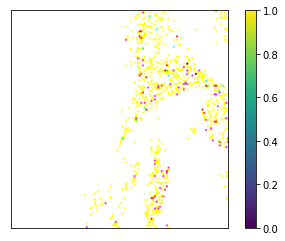

In [30]:
# 이미지 플롯
plt.figure()
plt.imshow(tf.squeeze(sample_low_image_1[2]*255.0))
plt.colorbar()
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

# 4.U-Net

## 4.1.모델

In [ ]:
# U-Net
def unet(sz=(256, 256, 3), class_num: int=2):
  base_num_filter = 16

  input = Input(sz)
  
  # Encoding
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(input)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  skip1 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  skip2 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  skip3 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  skip4 = x

  x = MaxPooling2D()(x)
  
  # BottleNeck
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)
  
  # Decoding
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip4])
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip3])
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip2])
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip1])
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  
  output = Conv2D(class_num, 1, activation='sigmoid' if class_num == 1 else 'softmax')(x)
  
  # model creation
  model = Model(inputs=[input], outputs=[output])
  
  return model

In [ ]:
CLASS_NUM = 12

model = unet(class_num=CLASS_NUM)
model.compile(
    optimizer='rmsprop', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])
    # metrics=[tf.keras.metrics.MeanIoU(num_classes=CLASS_NUM)])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_69 (Conv2D)             (None, 256, 256, 16  448         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 256, 256, 16  2320        ['conv2d_69[0][0]']              
                                )                                                           

## 4.2.모델 트레이닝

In [ ]:
# inheritance for training process plot 
import cv2

class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1

        # [선택] 랜덤으로 검증 이미지 선택
        val_sample_img, val_sample_mask = list(val_dataset.shuffle(1000).take(1))[0]
        
        # [예측] 선택된 이미지에 대해 예측
        pred = model.predict(np.expand_dims(val_sample_img, 0))
        
        # [후처리] 예측 결과 후처리
        msk = tf.squeeze(pred)
        msk = tf.argmax(msk, axis=-1)[..., tf.newaxis]
        
        # 디스플레이
        f, axarr = plt.subplots(1, 3, figsize=(16, 6))
        axarr[0].axis('off')
        axarr[1].axis('off')
        axarr[2].axis('off')
        axarr[0].imshow(tf.cast(val_sample_img*255.0, tf.uint8))
        axarr[0].set_title('Image')
        axarr[1].imshow(tf.squeeze(msk))
        axarr[1].set_title('Predicted')
        axarr[2].imshow(tf.squeeze(tf.cast(val_sample_mask, tf.uint8)))
        axarr[2].set_title('Target')
        plt.show()


In [ ]:
def build_callbacks():
    checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
    callbacks = [checkpointer, PlotLearning()]
    return callbacks


데이터 세트 배치로 전환

In [ ]:
BATCH_SIZE = 8

In [ ]:
batched_train_ds_1 = train_dataset.shuffle(1000).batch(BATCH_SIZE)
batched_val_ds_1 = val_dataset.batch(BATCH_SIZE)
batched_test_ds_1 = test_dataset.batch(BATCH_SIZE)

In [ ]:
history = model.fit(batched_train_ds_1, 
                    epochs=100, 
                    callbacks = build_callbacks(), 
                    validation_data=batched_val_ds_1)

Output hidden; open in https://colab.research.google.com to view.

[0.22918705642223358, 0.4077520966529846, 0.5562068223953247, 0.6160100698471069, 0.644855260848999, 0.6503221988677979, 0.673567533493042, 0.6778199672698975, 0.679792582988739, 0.6927531957626343, 0.7080458998680115, 0.7160293459892273, 0.7310820817947388, 0.7356075048446655, 0.7524245381355286, 0.7692094445228577, 0.7799288630485535, 0.795354962348938, 0.7945964336395264, 0.8099895715713501, 0.8186279535293579, 0.8238714337348938, 0.8098359704017639, 0.8333110213279724, 0.8270915746688843, 0.847623348236084, 0.8449852466583252, 0.8497264385223389, 0.8547224998474121, 0.8595691919326782, 0.8537434935569763, 0.8640041351318359, 0.864842414855957, 0.8685550689697266, 0.8728602528572083, 0.8771469593048096, 0.8722077012062073, 0.8792557716369629, 0.8846102952957153, 0.883633553981781, 0.8857406973838806, 0.8922761678695679, 0.8878344893455505, 0.8961076736450195, 0.8868082165718079, 0.8988615274429321, 0.903820812702179, 0.9011163711547852, 0.9042268395423889, 0.9021260738372803, 0.9094

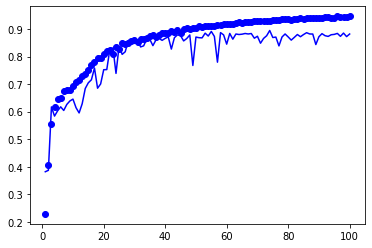

In [ ]:
history_accuracy = history.history["accuracy"]
history_val_accuracy = history.history["val_accuracy"]

epochs = range(1, len(history_accuracy) + 1)
plt.plot(epochs, history_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, history_val_accuracy, "b", label="Validation accuracy")

print(history_accuracy)
print(history_val_accuracy)

[1.7977042198181152, 1.4015464782714844, 1.261003017425537, 1.1617826223373413, 1.1205252408981323, 1.013932704925537, 0.9756169319152832, 0.9646260738372803, 0.9137101173400879, 0.8766365647315979, 0.8453636765480042, 0.8054857850074768, 0.8044971823692322, 0.7617152333259583, 0.7358561158180237, 0.7087112069129944, 0.6765548586845398, 0.6679774522781372, 0.6203246712684631, 0.5993329882621765, 0.5887521505355835, 0.6425018906593323, 0.5492876172065735, 0.5864698886871338, 0.5098106265068054, 0.511184573173523, 0.5016657710075378, 0.47939959168434143, 0.46292346715927124, 0.47944146394729614, 0.44778692722320557, 0.44410252571105957, 0.42693352699279785, 0.41464272141456604, 0.4039798974990845, 0.4206211268901825, 0.39123502373695374, 0.37805572152137756, 0.3785642385482788, 0.36867180466651917, 0.3526719808578491, 0.365989625453949, 0.33707940578460693, 0.36791327595710754, 0.32506898045539856, 0.30701643228530884, 0.3177051544189453, 0.3098824918270111, 0.32145974040031433, 0.289600

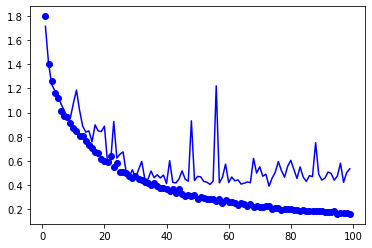

In [ ]:
history_loss = history.history["loss"][1:]
history_val_loss = history.history["val_loss"][1:]

epochs = range(1, len(history_loss) + 1)
plt.plot(epochs, history_loss, "bo", label="Training loss")
plt.plot(epochs, history_val_loss, "b", label="Validation loss")

print(history_loss)
print(history_val_loss)

## 4.3.모델 테스트 및 예측

In [ ]:
test_loss, test_acc = model.evaluate(batched_test_ds_1)
print('테스트 정확도:', test_acc)

30/30 [==============================] - 4s 124ms/step - loss: 1.1729 - accuracy: 0.7853
테스트 정확도: 0.7852721810340881


In [ ]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2022-07-21 07:31:04--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.227.219.35, 13.227.219.119, 13.227.219.34, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.227.219.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.005s  

2022-07-21 07:31:04 (13.3 MB/s) - ‘test.jpg’ saved [63219/63219]



In [ ]:
import cv2
img = cv2.imread('test.jpg')
img.shape

(720, 720, 3)

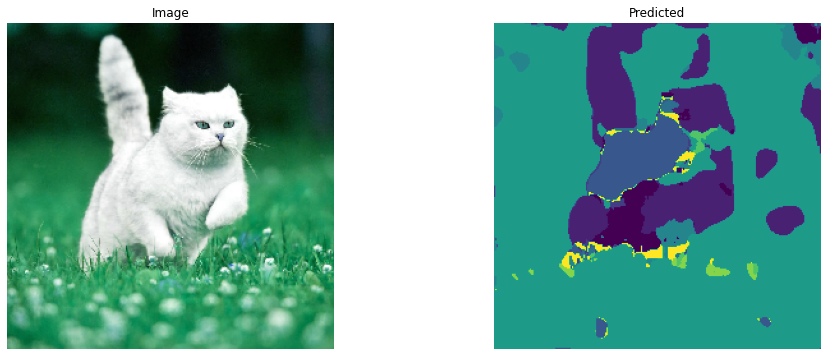

In [ ]:
# [선택] 랜덤으로 검증 이미지 선택
img = cv2.imread('test.jpg')
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
img = img / 255.

# [예측] 선택된 이미지에 대해 예측
pred = model.predict(np.expand_dims(img, 0))

# [후처리] 예측 결과 후처리
msk = tf.squeeze(pred)
msk = tf.argmax(msk, axis=-1)[..., tf.newaxis]

# 디스플레이
f, axarr = plt.subplots(1, 2, figsize=(16, 6))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[0].imshow(tf.cast(img*255.0, tf.uint8))
axarr[0].set_title('Image')
axarr[1].imshow(tf.squeeze(msk))
axarr[1].set_title('Predicted')
plt.show()